In [151]:
import pylab as plt
import xarray as xr
import pint_xarray
from pathlib import Path
import numpy as np
import matplotlib.ticker as ticker

from pism_ragis.observations import load_imbie, load_mouginot

In [91]:
    mass_cumulative_varname = "Cumulative ice sheet mass change (Gt)"
    mass_cumulative_uncertainty_varname = (
        "Cumulative ice sheet mass change uncertainty (Gt)"
    )
    mass_flux_varname = "Rate of ice sheet mass change (Gt/yr)"
    mass_flux_uncertainty_varname = "Rate of ice sheet mass change uncertainty (Gt/yr)"

    discharge_cumulative_varname = "Cumulative ice discharge anomaly (Gt)"
    discharge_cumulative_uncertainty_varname = (
        "Cumulative ice discharge anomaly uncertainty (Gt)"
    )
    discharge_flux_varname = "Rate of ice discharge (Gt/yr)"
    discharge_flux_uncertainty_varname = "Rate of ice discharge uncertainty (Gt/yr)"

    smb_cumulative_varname = "Cumulative surface mass balance anomaly (Gt)"
    smb_cumulative_uncertainty_varname = (
        "Cumulative surface mass balance anomaly uncertainty (Gt)"
    )
    smb_flux_varname = "Rate of surface mass balance (Gt/yr)"
    smb_flux_uncertainty_varname = "Rate of surface mass balance uncertainty (Gt/yr)"

    basal_flux_varname = "tendency_of_ice_mass_due_to_basal_mass_flux"
    basal_grounded_flux_varname = "tendency_of_ice_mass_due_to_basal_mass_flux_grounded"
    basal_floating_flux_varname = "tendency_of_ice_mass_due_to_basal_mass_flux_floating"

    sim_mass_cumulative_varname = "ice_mass"
    sim_mass_flux_varname = "tendency_of_ice_mass"
    sim_smb_flux_varname = "tendency_of_ice_mass_due_to_surface_mass_flux"
    sim_discharge_flux_varname = "ice_mass_transport_across_grounding_line"


In [5]:
mouginot_url = Path("/mnt/storstrommen/data/mouginot/pnas.1904242116.sd02.xlsx")
mouginot_url = Path("/Users/andy/Google Drive/My Drive/data/mouginot_discharge/pnas.1904242116.sd02.xlsx")

# Load observations
imbie = load_imbie()
mou = load_mouginot(url=mouginot_url, norm_year=1980)
mou[discharge_flux_varname] = -mou[discharge_flux_varname]
mou_gis = mou[mou["Basin"] == "GIS"]

imbie_mean = imbie[imbie.Date.between("1992-1-1", "2012-1-1")][
[
    mass_flux_uncertainty_varname,
    smb_flux_uncertainty_varname,
    discharge_flux_uncertainty_varname,
    ]
].mean()
mou_mean = mou[mou.Date.between("1992-1-1", "2012-1-1")][
[
    mass_flux_uncertainty_varname,
    smb_flux_uncertainty_varname,
    discharge_flux_uncertainty_varname,        ]
].mean()
u_ratio = imbie_mean / mou_mean / 2
sigma_adjusted = np.maximum(u_ratio, 1)

In [6]:
sigma_adjusted

Rate of ice sheet mass change uncertainty (Gt/yr)     2.238989
Rate of surface mass balance uncertainty (Gt/yr)      2.886524
Rate of ice discharge uncertainty (Gt/yr)            10.434424
dtype: float64

In [72]:
ds_ctrl = xr.open_mfdataset("../analysis/2024_07_ragis_ctrl/basins_sums_ensemble_RAGIS_id_BM-*.nc")
ds_ctrl = ds_ctrl.sel(ensemble_id="RAGIS").sel(time=slice("1980-01-01", "2020-01-01"))
ds_ctrl[sim_mass_cumulative_varname] -= ds_ctrl.sel(time="1980-01-01", method="nearest")[sim_mass_cumulative_varname]
ds_ctrl[sim_discharge_flux_varname] += ds_ctrl["tendency_of_ice_mass_due_to_basal_mass_flux_grounded"]
ds_ctrl = ds_ctrl.rolling(time=13).mean()

In [73]:
ds_tw = xr.open_mfdataset("../analysis/2024_07_ragis_tw/basins_sums_ensemble_RAGIS_id_BM-*.nc")
ds_tw = ds_tw.sel(ensemble_id="RAGIS").sel(time=slice("1980-01-01", "2020-01-01"))
ds_tw[sim_mass_cumulative_varname] -= ds_tw.sel(time="1980-01-01", method="nearest")[sim_mass_cumulative_varname]
ds_tw[sim_discharge_flux_varname] += ds_tw["tendency_of_ice_mass_due_to_basal_mass_flux_grounded"]
ds_tw = ds_tw.rolling(time=13).mean()

In [74]:
ds_tw_scalar = xr.open_mfdataset("/mnt/storstrommen/ragis/data/pism/2024_06_ragis_tw/scalar/ts_gris_g900m_v2024-02_RAGIS_id_BM-FR-SC-1.1-VCM-0.45_1975-1-1_2020-1-1.nc").pint.quantify()
ds_tw_scalar = ds_tw_scalar.rolling(time=13).mean()
ds_tw_scalar[[sim_mass_cumulative_varname, "limnsw"]] -= ds_tw_scalar.sel(time="1980-01-01", method="nearest")[[sim_mass_cumulative_varname, "limnsw"]]

OSError: no files to open

In [120]:
mb = (ds_tw["tendency_of_ice_mass_due_to_surface_mass_flux"] + ds_tw["ice_mass_transport_across_grounding_line"]).cumsum() / 12
mb -= mb.sel(time="1980-01-01", method="nearest")
mb_with_bmb = (ds_tw["tendency_of_ice_mass_due_to_surface_mass_flux"] + ds_tw["ice_mass_transport_across_grounding_line"] + ds_tw[basal_floating_flux_varname]).cumsum() / 12
mb_with_bmb -= mb_with_bmb.sel(time="1980-01-01", method="nearest")

In [113]:
ds_tw.sel(basin="GIS")[sim_discharge_flux_varname].cumsum?

Object `cumsum` not found.


['forced retreat', 'control']


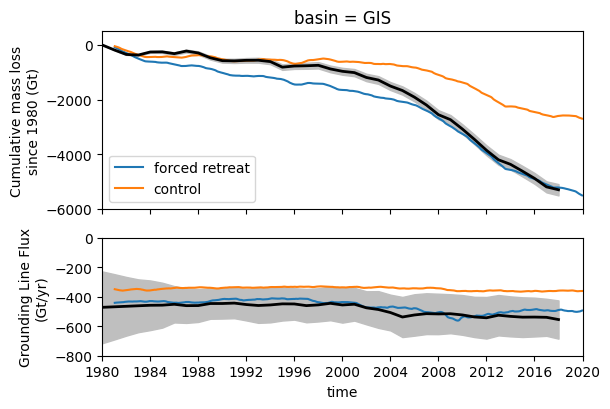

In [161]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6.2, 4.2), height_ratios=[3, 2])
f = ds_tw.sel(basin="GIS")[sim_mass_cumulative_varname].plot.line(x="time", hue="exp_id", ax=axs[0], label=["forced retreat", "control"])
labels = [l.get_label() for l in f]
axs[0].fill_between(mou_gis["Date"], 
                mou_gis[mass_cumulative_varname] - mou_gis[mass_cumulative_uncertainty_varname], 
                mou_gis[mass_cumulative_varname] + mou_gis[mass_cumulative_uncertainty_varname], color="0.75")
axs[0].plot(mou_gis["Date"], mou_gis["Cumulative ice sheet mass change (Gt)"], color="k", lw=2)

ds_tw.sel(basin="GIS")[sim_discharge_flux_varname].plot.line(x="time", hue="exp_id", add_legend=False, ax=axs[1])
axs[1].fill_between(mou_gis["Date"], 
                mou_gis[discharge_flux_varname] - sigma_adjusted[discharge_flux_uncertainty_varname] * mou_gis[discharge_flux_uncertainty_varname], 
                mou_gis[discharge_flux_varname] + sigma_adjusted[discharge_flux_uncertainty_varname] * mou_gis[discharge_flux_uncertainty_varname], color="0.75")
axs[1].plot(mou_gis["Date"], mou_gis[discharge_flux_varname], color="k", lw=2, )
print(labels)
axs[0].legend(labels)
axs[0].set_ylim(-6000, 500)
axs[0].xaxis.set_tick_params(labelbottom=False)

axs[0].set_ylabel("Cumulative mass loss\nsince 1980 (Gt)")
axs[0].set_xlabel("")
axs[0].set_title("basin = GIS")
axs[1].set_title("")
axs[1].set_ylim(-800, 0)
axs[1].set_ylabel("Grounding Line Flux\n(Gt/yr)")
axs[-1].set_xlim(np.datetime64("1980-01-01"), np.datetime64("2020-01-01"))
fig.tight_layout()
fig.savefig("GIS_mass_accounting.pdf")

(3652.0, 18262.0)

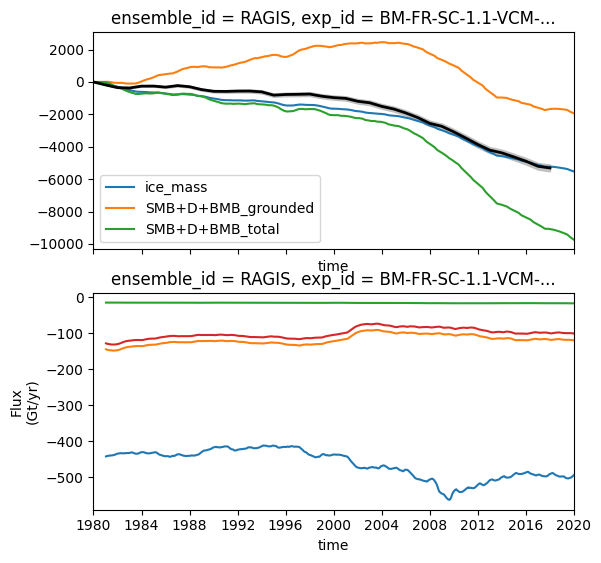

In [139]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6.2, 6.2), height_ratios=[3, 3])
labels = []
f = ds_tw.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45")[sim_mass_cumulative_varname].plot.line(x="time", ax=axs[0], label="ice_mass")
labels.append(f[0].get_label())
f = mb.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45").plot.line(ax=axs[0], label="SMB+D+BMB_grounded")
labels.append(f[0].get_label())
f= mb_with_bmb.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45").plot.line(ax=axs[0], label="SMB+D+BMB_total")
labels.append(f[0].get_label())
axs[0].fill_between(mou_gis["Date"], 
                mou_gis[mass_cumulative_varname] - mou_gis[mass_cumulative_uncertainty_varname], 
                mou_gis[mass_cumulative_varname] + mou_gis[mass_cumulative_uncertainty_varname], color="0.75")
axs[0].plot(mou_gis["Date"], mou_gis["Cumulative ice sheet mass change (Gt)"], color="k", lw=2)


ds_tw.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45")[sim_discharge_flux_varname].plot.line(x="time", add_legend=False, ax=axs[1])
ds_tw.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45")[basal_flux_varname].plot.line(x="time", add_legend=False, ax=axs[1])
ds_tw.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45")[basal_grounded_flux_varname].plot.line(x="time", add_legend=False, ax=axs[1])
ds_tw.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45")[basal_floating_flux_varname].plot.line(x="time", add_legend=False, ax=axs[1])
axs[0].legend(labels)
axs[1].set_ylabel("Flux\n(Gt/yr)")
axs[-1].set_xlim(np.datetime64("1980-01-01"), np.datetime64("2020-01-01"))

In [133]:
f[0].get_label()

'foo'

(3652.0, 18262.0)

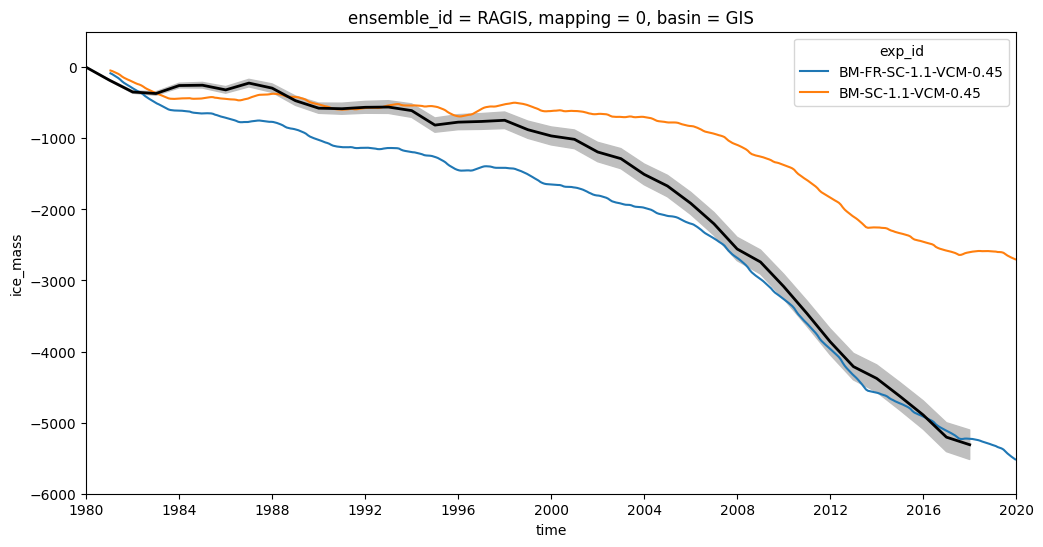

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# ds_ctrl.sel(basin="GIS").sel(exp_id="BM-FR-SC-1.1-VCM-0.45")[sim_mass_cumulative_varname].plot.line(x="time", hue="exp_id", ax=ax)
ds_tw.sel(basin="GIS")[sim_mass_cumulative_varname].plot.line(x="time", hue="exp_id", ax=ax)
ax.fill_between(mou_gis["Date"], 
                mou_gis[mass_cumulative_varname] - mou_gis[mass_cumulative_uncertainty_varname], 
                mou_gis[mass_cumulative_varname] + mou_gis[mass_cumulative_uncertainty_varname], color="0.75")
ax.plot(mou_gis["Date"], mou_gis["Cumulative ice sheet mass change (Gt)"], color="k", lw=2)
#ds_tw_scalar[sim_mass_cumulative_varname].pint.to("Gt").plot.line(ax=ax)
#ds_tw_scalar["limnsw"].pint.to("Gt").plot.line(ax=ax)
ax.set_ylim(-6000, 500)
ax.set_xlim(np.datetime64("1980-01-01"), np.datetime64("2020-01-01"))

In [126]:
f

(3652.0, 18262.0)

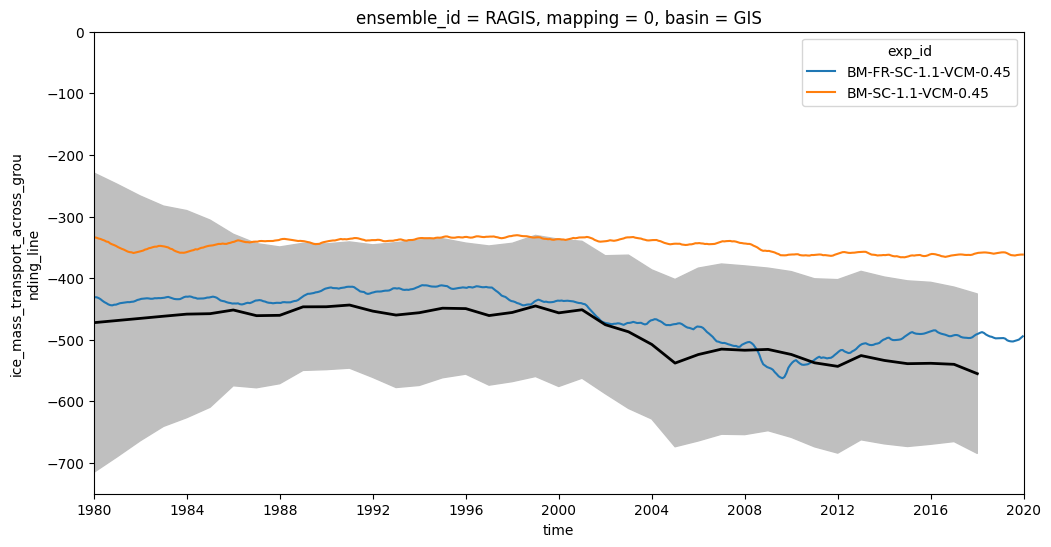

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# ds_ctrl.sel(basin="GIS").sel(exp_id="BM-FR-SC-1.1-VCM-0.45")[sim_discharge_flux_varname].plot.line(x="time", hue="exp_id", ax=ax)
ds_tw.sel(basin="GIS")[sim_discharge_flux_varname].plot.line(x="time", hue="exp_id", ax=ax)
ax.fill_between(mou_gis["Date"], 
                mou_gis[discharge_flux_varname] - sigma_adjusted[discharge_flux_uncertainty_varname] * mou_gis[discharge_flux_uncertainty_varname], 
                mou_gis[discharge_flux_varname] + sigma_adjusted[discharge_flux_uncertainty_varname] * mou_gis[discharge_flux_uncertainty_varname], color="0.75")
ax.plot(mou_gis["Date"], mou_gis["Rate of ice discharge (Gt/yr)"], color="k", lw=2)
ax.set_ylim(-750, 0)
ax.set_xlim(np.datetime64("1980-01-01"), np.datetime64("2020-01-01"))

NameError: name 'ds_tw_scalar' is not defined

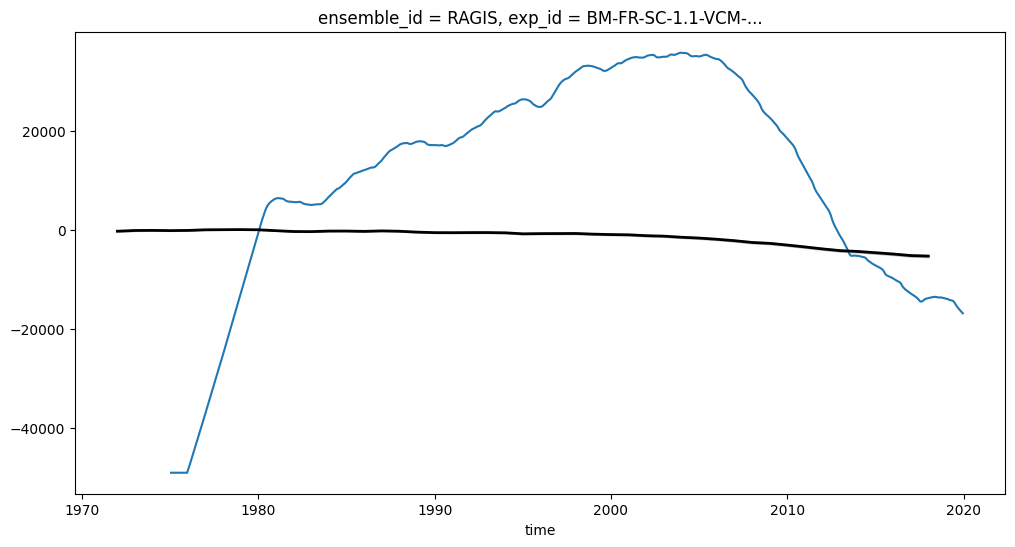

In [57]:


fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# ds_ctrl.sel(basin="GIS").sel(exp_id="BM-FR-SC-1.1-VCM-0.45")[sim_mass_cumulative_varname].plot.line(x="time", hue="exp_id", ax=ax)
# ds_tw.sel(basin="GIS")[sim_mass_cumulative_varname].plot.line(x="time", hue="exp_id", ax=ax)
mb.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45").plot.line(ax=ax)
ax.fill_between(mou_gis["Date"], 
                mou_gis[mass_cumulative_varname] - mou_gis[mass_cumulative_uncertainty_varname], 
                mou_gis[mass_cumulative_varname] + mou_gis[mass_cumulative_uncertainty_varname], color="0.75")
ax.plot(mou_gis["Date"], mou_gis["Cumulative ice sheet mass change (Gt)"], color="k", lw=2)
ds_tw_scalar[sim_mass_cumulative_varname].pint.to("Gt").plot.line(ax=ax)
ds_tw_scalar["limnsw"].pint.to("Gt").plot.line(ax=ax)
ax.set_ylim(-6000, 500)
ax.set_xlim(np.datetime64("1980-01-01"), np.datetime64("2020-01-01"))

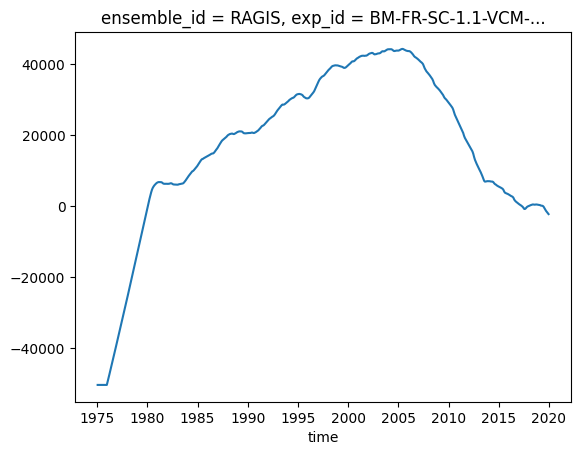

In [61]:
mb.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45").plot.line()

# ds.data_vars

In [78]:
ds_tw.data_vars

Data variables:
    ice_mass                                              (basin, exp_id, time) float32 35kB dask.array<chunksize=(8, 1, 540), meta=np.ndarray>
    ice_mass_transport_across_grounding_line              (basin, exp_id, time) float32 35kB dask.array<chunksize=(8, 1, 540), meta=np.ndarray>
    tendency_of_ice_mass                                  (basin, exp_id, time) float32 35kB dask.array<chunksize=(8, 1, 540), meta=np.ndarray>
    tendency_of_ice_mass_due_to_basal_mass_flux           (basin, exp_id, time) float32 35kB dask.array<chunksize=(8, 1, 540), meta=np.ndarray>
    tendency_of_ice_mass_due_to_basal_mass_flux_grounded  (basin, exp_id, time) float32 35kB dask.array<chunksize=(8, 1, 540), meta=np.ndarray>
    tendency_of_ice_mass_due_to_basal_mass_flux_floating  (basin, exp_id, time) float32 35kB dask.array<chunksize=(8, 1, 540), meta=np.ndarray>
    tendency_of_ice_mass_due_to_discharge                 (basin, exp_id, time) float32 35kB dask.array<chunksize=(8, 1,

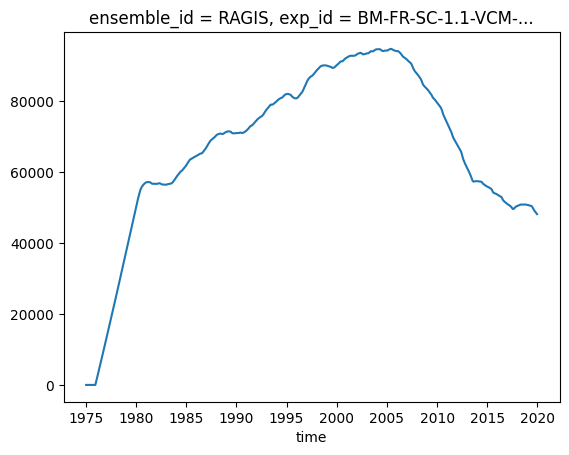

In [72]:
mb.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45").plot()

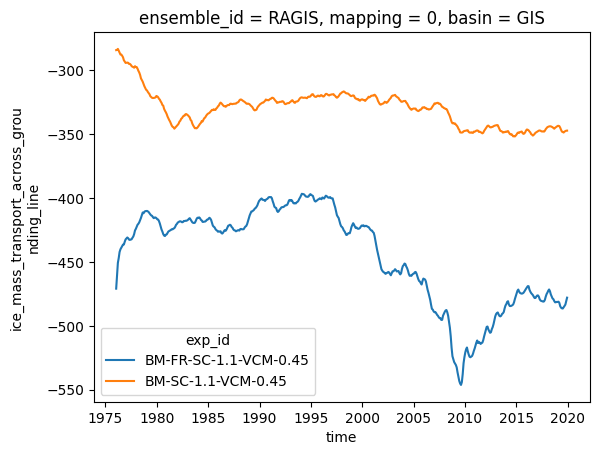

In [73]:
ds_tw.sel(basin="GIS")[sim_discharge_flux_varname].plot(hue="exp_id")

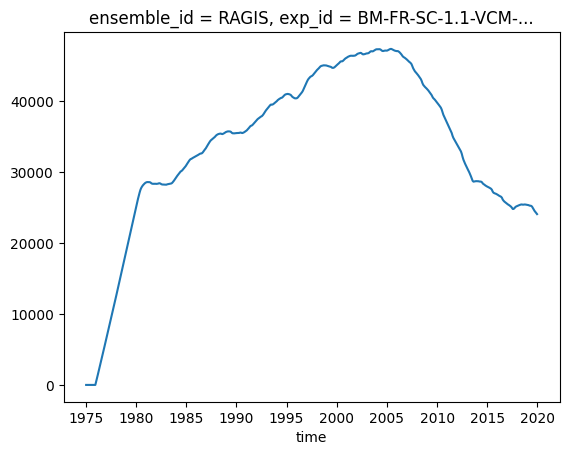

In [76]:
(ds_tw.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45")[sim_discharge_flux_varname] + ds_tw.sel(basin="GIS", exp_id="BM-FR-SC-1.1-VCM-0.45")["tendency_of_ice_mass_due_to_surface_mass_flux"]).cumsum().plot()

In [44]:
plt.subplots?

Signature:
plt.subplots(
    nrows: 'int' = 1,
    ncols: 'int' = 1,
    *,
    sharex: "bool | Literal['none', 'all', 'row', 'col']" = False,
    sharey: "bool | Literal['none', 'all', 'row', 'col']" = False,
    squeeze: 'bool' = True,
    width_ratios: 'Sequence[float] | None' = None,
    height_ratios: 'Sequence[float] | None' = None,
    subplot_kw: 'dict[str, Any] | None' = None,
    gridspec_kw: 'dict[str, Any] | None' = None,
    **fig_kw,
) -> 'tuple[Figure, Any]'
Docstring:
Create a figure and a set of subplots.

This utility wrapper makes it convenient to create common layouts of
subplots, including the enclosing figure object, in a single call.

Parameters
----------
nrows, ncols : int, default: 1
    Number of rows/columns of the subplot grid.

sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
    Controls sharing of properties among x (*sharex*) or y (*sharey*)
    axes:

    - True or 'all': x- or y-axis will be shared among all subplots.
    - False